In [11]:
# module import
import pandas as pd
import numpy as np
import pathlib as pt
import os
import os.path as op
import matplotlib.pyplot as plt

In [12]:
# filepath and file name
owd = os.getcwd()
home = str(owd)
directory = 'Source Files'
os.chdir(f'{home}/{directory}')
all_fns = os.listdir(str(os.getcwd()))
fns = [fn for fn in all_fns if fn.endswith('.xlsx')]
os.chdir(owd)

rounds = []
matches = []
round_player_stats = []

for fn in fns:
    rounds.append(pd.read_excel(os.path.join(home, directory, fn), sheet_name='Rounds'))
    matches.append(pd.read_excel(os.path.join(home, directory, fn), sheet_name='Matches'))
    round_player_stats.append(pd.read_excel(os.path.join(home, directory, fn), sheet_name='Round Player Stats'))

df_rounds = pd.concat(rounds, axis=0, ignore_index=True)
df_matches = pd.concat(matches, axis=0, ignore_index=True)
df_round_player_stats = pd.concat(round_player_stats, axis=0, ignore_index=True)

# making various outcome dataframes
df_rounds["halfScore"] = df_rounds[df_rounds.half == 'first'].groupby(['matchId', 'winningTeamId']).transform("size")
df7_5 = df_rounds.loc[df_rounds['halfScore'].isin([7])]
df8_4 = df_rounds.loc[df_rounds['halfScore'].isin([8])]
df9_3 = df_rounds.loc[df_rounds['halfScore'].isin([9])]
df10_2 = df_rounds.loc[df_rounds['halfScore'].isin([10])]
df11_1 = df_rounds.loc[df_rounds['halfScore'].isin([11])]
df12_0 = df_rounds.loc[df_rounds['halfScore'].isin([12])]
# TODO: INSPECTION AND CLEANING OF DATA

# array of various outcomes
outcomes = ["7-5","8-4","9-3","10-2","11-1","12-0"]
dataframes = [df7_5, df8_4, df9_3, df10_2, df11_1, df12_0]
result = {}

In [13]:
for i, df in enumerate(dataframes):
    first_half_scores = df.groupby(['matchId', 'winningTeamId','attackingTeamId']).aggregate(score=('winningTeamId','count')).reset_index()
    first_half_scores = first_half_scores.rename(columns = {'winningTeamId': 'leadingTeamId', 'attackingTeamId': 'firstHalfAtkTeamId'})
    df_outcome_matches = pd.DataFrame(pd.unique(df['matchId']), columns = ['MatchId_matches_df'])

    # creating overall summary
    match_with_leading = df_outcome_matches.merge(first_half_scores, how="left", left_on="MatchId_matches_df", right_on="matchId")
    df_summary = match_with_leading.merge(df_matches, how="left", left_on="MatchId_matches_df", right_on="matchId").loc[:,['MatchId_matches_df','map','teamOneId','teamOneName','teamTwoId','teamTwoName','firstHalfAtkTeamId','winningTeamId','leadingTeamId']]
    df_summary['comeback'] = np.where(df_summary['winningTeamId'] != df_summary['leadingTeamId'], True, False)
    df_summary['trailingTeam2ndHalfSide'] = np.where(df_summary['firstHalfAtkTeamId'] != df_summary['leadingTeamId'], "Def", "Atk")

    # calculating comeback probability
    comebackProbability = df_summary[df_summary['comeback'] == True]['comeback'].aggregate('count') / df_summary['comeback'].aggregate('count')
    comebackProbability_Atk = df_summary[(df_summary['comeback'] == True) & (df_summary['trailingTeam2ndHalfSide'] == "Atk")]['comeback'].aggregate('count') / df_summary[df_summary['trailingTeam2ndHalfSide'] == "Atk"]['comeback'].aggregate('count')
    comebackProbability_Def = df_summary[(df_summary['comeback'] == True) & (df_summary['trailingTeam2ndHalfSide'] == "Def")]['comeback'].aggregate('count') / df_summary[df_summary['trailingTeam2ndHalfSide'] == "Def"]['comeback'].aggregate('count')

    # comeback per map per side
    map_comeback = df_summary[~df_summary['comeback']].groupby(['map','trailingTeam2ndHalfSide']).aggregate(comeback_occurrence=('comeback', 'count')).reset_index()
    merge_map = df_summary.groupby(['map','trailingTeam2ndHalfSide']).aggregate(total_occurrence=('comeback','count'))
    map_comeback = map_comeback.merge(merge_map, how="left", left_on=['map','trailingTeam2ndHalfSide'], right_on=['map','trailingTeam2ndHalfSide'])
    
    map_comeback['comeback_occurrence'] = map_comeback['total_occurrence'] - map_comeback['comeback_occurrence']
    map_comeback['comeback_probability'] = map_comeback['comeback_occurrence'] / map_comeback['total_occurrence']
    
    # team clutch stats
    team_clutch_stats = df_round_player_stats.loc[:,['matchId','teamId','clutches','clutchOpportunities']].groupby(['matchId', 'teamId']).aggregate('sum').reset_index()
    clutch_matches = df_outcome_matches.merge(team_clutch_stats, how="left", left_on="MatchId_matches_df", right_on="matchId").loc[:,['matchId','teamId','clutches','clutchOpportunities']]
    clutch_matches = clutch_matches.merge(df_summary.loc[:,['MatchId_matches_df','leadingTeamId','comeback']], how="left", left_on="matchId", right_on="MatchId_matches_df").loc[:,['matchId','teamId','leadingTeamId','clutches','clutchOpportunities','comeback']]
    
    # getting losing teams at half
    trailers_clutches = clutch_matches.loc[clutch_matches["teamId"] != clutch_matches["leadingTeamId"]]
    trailers_clutches = trailers_clutches.loc[:,['comeback','clutches','clutchOpportunities']].groupby(['comeback']).aggregate('sum')
    trailers_clutches['clutch_percentage'] = trailers_clutches['clutches'] / trailers_clutches['clutchOpportunities']

    # kills to comebacks
    player_kill_stats = df_round_player_stats.loc[df_round_player_stats['kills']>=3,['matchId','teamId','playerId','kills']].groupby(['matchId', 'teamId','playerId']).agg(killstreak=('kills','count')).reset_index()
    player_kill_stats = player_kill_stats.loc[:,['matchId','teamId','killstreak']].groupby(['matchId', 'teamId']).aggregate("sum").reset_index()
    kills_comebacks = df_outcome_matches.merge(player_kill_stats, how="left", left_on="MatchId_matches_df", right_on="matchId").loc[:,['matchId','teamId','killstreak']]
    kills_comebacks_summary = kills_comebacks.merge(df_summary, how="left", left_on="matchId", right_on="MatchId_matches_df").loc[:,['matchId','winningTeamId','leadingTeamId','teamId','comeback','killstreak']]
    kills_comebacks_summary['result'] = np.where(kills_comebacks_summary['winningTeamId'] != kills_comebacks_summary['teamId'], "Loser", "Winner")
    successcomeback_kills = kills_comebacks_summary.loc[kills_comebacks_summary['comeback']== True,['result','killstreak']].groupby(['result']).agg(ave_killstreak=('killstreak','mean')).reset_index()
    failcomeback_kills = kills_comebacks_summary.loc[kills_comebacks_summary['comeback']== False,['result','killstreak']].groupby(['result']).agg(ave_killstreak=('killstreak','mean')).reset_index()

    # storing results
    result[outcomes[i]] = {
        "summary": df_summary,
        "overallComebackProbability": comebackProbability,
        "atkComebackProbability": comebackProbability_Atk,
        "defComebackProbability": comebackProbability_Def,
        "mapComeback": map_comeback,
        "losingteamClutches": trailers_clutches,
        "successfulComebacksKills": successcomeback_kills,
        "failComebacksKills": failcomeback_kills
    }

In [14]:
# all outputs
# for res in result:
#     display(res)
#     for x in result[res]:
#         display(x, result[res][x])

In [15]:
# df.to_csv('file_name.csv', index=False)

In [16]:
x_comeback = []
y_comeback = []
for res in result:
    x_comeback.append(res)
    y_comeback.append(result[res]["overallComebackProbability"])

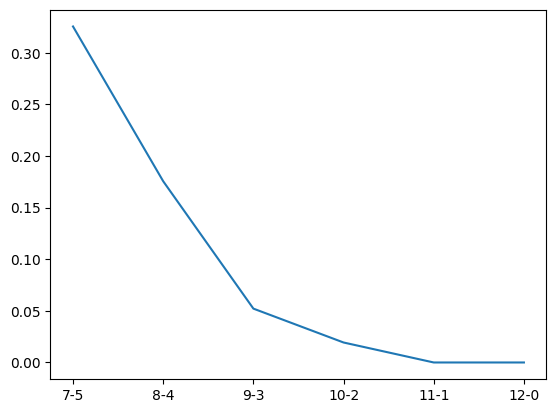

In [17]:
plt.figure()
plt.plot(x_comeback,y_comeback)
plt.show()

In [24]:
print(x_comeback, '\n', y_comeback)

['7-5', '8-4', '9-3', '10-2', '11-1', '12-0'] 
 [0.32547864506627394, 0.17555938037865748, 0.05217391304347826, 0.01935483870967742, 0.0, 0.0]


In [18]:
result['9-3']["mapComeback"]

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,0,35,0.000000
1,Ascent,Def,4,60,0.066667
2,Bind,Atk,2,32,0.062500
3,Bind,Def,0,25,0.000000
4,Breeze,Atk,0,18,0.000000
5,Breeze,Def,1,22,0.045455
6,Fracture,Atk,1,20,0.050000
7,Fracture,Def,1,20,0.050000
8,Haven,Atk,1,53,0.018868
9,Haven,Def,2,36,0.055556


In [19]:
for res in result:
    display(res)
    display(result[res]["mapComeback"])

'7-5'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,15,59,0.254237
1,Ascent,Def,15,47,0.319149
2,Bind,Atk,10,45,0.222222
3,Bind,Def,10,39,0.256410
4,Breeze,Atk,13,45,0.288889
5,Breeze,Def,20,53,0.377358
6,Fracture,Atk,11,28,0.392857
7,Fracture,Def,14,36,0.388889
8,Haven,Atk,23,68,0.338235
9,Haven,Def,19,72,0.263889


'8-4'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,5,51,0.098039
1,Ascent,Def,10,46,0.217391
2,Bind,Atk,13,37,0.351351
3,Bind,Def,5,50,0.100000
4,Breeze,Atk,7,40,0.175000
5,Breeze,Def,4,30,0.133333
6,Fracture,Atk,5,27,0.185185
7,Fracture,Def,4,24,0.166667
8,Haven,Atk,12,57,0.210526
9,Haven,Def,5,52,0.096154


'9-3'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,0,35,0.000000
1,Ascent,Def,4,60,0.066667
2,Bind,Atk,2,32,0.062500
3,Bind,Def,0,25,0.000000
4,Breeze,Atk,0,18,0.000000
5,Breeze,Def,1,22,0.045455
6,Fracture,Atk,1,20,0.050000
7,Fracture,Def,1,20,0.050000
8,Haven,Atk,1,53,0.018868
9,Haven,Def,2,36,0.055556


'10-2'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,0,25,0.000000
1,Ascent,Def,2,36,0.055556
2,Bind,Atk,1,21,0.047619
3,Bind,Def,0,22,0.000000
4,Breeze,Atk,0,23,0.000000
5,Breeze,Def,0,18,0.000000
6,Fracture,Atk,1,15,0.066667
7,Fracture,Def,0,13,0.000000
8,Haven,Atk,1,24,0.041667
9,Haven,Def,0,21,0.000000


'11-1'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,0,5,0.0
1,Ascent,Def,0,18,0.0
2,Bind,Atk,0,17,0.0
3,Bind,Def,0,5,0.0
4,Breeze,Atk,0,6,0.0
5,Breeze,Def,0,11,0.0
6,Fracture,Atk,0,6,0.0
7,Fracture,Def,0,5,0.0
8,Haven,Atk,0,9,0.0
9,Haven,Def,0,20,0.0


'12-0'

,map,trailingTeam2ndHalfSide,comeback_occurrence,total_occurrence,comeback_probability
0,Ascent,Atk,0,2,0.0
1,Ascent,Def,0,8,0.0
2,Bind,Atk,0,3,0.0
3,Bind,Def,0,3,0.0
4,Breeze,Atk,0,2,0.0
5,Breeze,Def,0,5,0.0
6,Haven,Atk,0,5,0.0
7,Haven,Def,0,7,0.0
8,Icebox,Atk,0,3,0.0
9,Icebox,Def,0,6,0.0


In [20]:
# result["9-3"]["losingteamClutches"]
for res in result:
    display(res)
    display(result[res]["losingteamClutches"])

'7-5'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,747,6616,0.112908
True,464,2648,0.175227


'8-4'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,690,6779,0.101785
True,210,1303,0.161167


'9-3'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,506,6043,0.083733
True,50,309,0.161812


'10-2'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,270,4098,0.065886
True,14,87,0.160920


'11-1'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,72,1736,0.041475


'12-0'

,clutches,clutchOpportunities,clutch_percentage
comeback,,,
False,8,635,0.012598


In [21]:
display(x_comeback)
display(y_comeback)

['7-5', '8-4', '9-3', '10-2', '11-1', '12-0']

[0.32547864506627394,
 0.17555938037865748,
 0.05217391304347826,
 0.01935483870967742,
 0.0,
 0.0]

In [22]:
for res in result:
    display(res)
    display(result[res]["successfulComebacksKills"])
    display(result[res]["failComebacksKills"])

'7-5'

,result,ave_killstreak
0,Loser,5.172727
1,Winner,6.368182


,result,ave_killstreak
0,Loser,4.488938
1,Winner,6.223195


'8-4'

,result,ave_killstreak
0,Loser,5.509615
1,Winner,6.480000


,result,ave_killstreak
0,Loser,4.055085
1,Winner,6.008368


'9-3'

,result,ave_killstreak
0,Loser,5.750000
1,Winner,6.708333


,result,ave_killstreak
0,Loser,3.330166
1,Winner,5.928736


'10-2'

,result,ave_killstreak
0,Loser,5.0
1,Winner,7.6


,result,ave_killstreak
0,Loser,2.785965
1,Winner,5.631579


'11-1'

,result,ave_killstreak


,result,ave_killstreak
0,Loser,2.342342
1,Winner,5.435115


'12-0'

,result,ave_killstreak


,result,ave_killstreak
0,Loser,1.866667
1,Winner,5.714286
